# XGBoost


In [1]:
import os
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import json
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_curve, roc_auc_score, auc, recall_score, f1_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("lead_data_expanded.csv")
df.columns


Index(['School_District', 'School', 'County', 'num_lte_5ppb', 'num_gt_5ppb',
       'School_City', 'Ratio_free', 'Student_teacher_ratio',
       'American_Indian/Alaska_Native', 'Asian', 'Black', 'Hispanic', 'White',
       'Native_Hawaiian/Pacific_Islander', 'Two_or_More_Races', 'target_col',
       'percent_housing_pre_1950'],
      dtype='object')

In [3]:
df_copied = df.copy()

### Train test split

In [4]:
X = df_copied.drop(columns=['target_col','num_gt_5ppb','School','num_lte_5ppb','County'])

y = df_copied['target_col']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=40, stratify=y,)

### Pipeline

In [6]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

In [7]:
num_transformer = Pipeline([('imputer',SimpleImputer(strategy='median')), ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),('onehot',OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num',num_transformer,num_features),('cat', cat_transformer,cat_features)])

## XGBoost with hyperparameter tuning

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

### Based on ROC-AUC

In [10]:
rng = np.random.default_rng(seed=40)

In [11]:
parameters = { 'classifier__n_estimators' : rng.integers(100,500,size=10).tolist(),
              'classifier__learning_rate' : rng.uniform(0.01,0.3,size=10).tolist(),
              'classifier__max_depth' : rng.integers(3,10,size=10).tolist(),
               'classifier__subsample': rng.uniform(0.6, 1.0, size=5).tolist(),
               'classifier__gamma': rng.uniform(0, 5, size=5).tolist(),
               'classifier__colsample_bytree': rng.uniform(0.6, 1.0, size=5).tolist(),
               'classifier__min_child_weight': rng.integers(1, 10, size=5).tolist()
              }

outer_scores = []
best_params_list = []
roc_curves = []

metrics = {'f1': f1_score, 'recall': recall_score, 'accuracy': accuracy_score, 'roc_auc': roc_auc_score}


outer_results = {metric: [] for metric in metrics}



In [12]:

XGB_clf  = XGBClassifier(random_state=40, eval_metric = 'logloss')
XGB_final = Pipeline([('preprocessor', preprocessor),('classifier',XGB_clf)])

In [13]:


for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
    X_tr, X_te = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Inner CV 
    random_search = RandomizedSearchCV(estimator=XGB_final, param_distributions=parameters,n_iter=1000,
                                        cv=inner_cv, random_state=40,scoring='roc_auc', n_jobs=-1)
    random_search.fit(X_tr, y_tr)

    best_model = random_search.best_estimator_

        
    y_pred = best_model.predict(X_te)
    y_proba = best_model.predict_proba(X_te)[:, 1]

    
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr,tpr))

    # Metrics
    for metric_name, func in metrics.items():
        if metric_name == 'roc_auc':
            outer_results[metric_name].append(func(y_te, y_proba))
        else:
            outer_results[metric_name].append(func(y_te, y_pred))
    
    print(f"Fold {fold} : Best params: {random_search.best_params_} : F1: {outer_results['f1'][-1]:.4f} : Recall: {outer_results['recall'][-1]:.4f} : Accuracy: {outer_results['accuracy'][-1]:.4f} : ROC-AUC: {outer_results['roc_auc'][-1]:.4f}")






Fold 1 : Best params: {'classifier__subsample': 0.6559993468091732, 'classifier__n_estimators': 123, 'classifier__min_child_weight': 3, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.0238368818104888, 'classifier__gamma': 1.346515404689483, 'classifier__colsample_bytree': 0.7336983896576152} : F1: 0.6244 : Recall: 0.5981 : Accuracy: 0.6716 : ROC-AUC: 0.7247
Fold 2 : Best params: {'classifier__subsample': 0.7480172670905564, 'classifier__n_estimators': 112, 'classifier__min_child_weight': 2, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.0238368818104888, 'classifier__gamma': 2.158284722608922, 'classifier__colsample_bytree': 0.7674468256276166} : F1: 0.6619 : Recall: 0.6512 : Accuracy: 0.6951 : ROC-AUC: 0.7286
Fold 3 : Best params: {'classifier__subsample': 0.8118566606613612, 'classifier__n_estimators': 108, 'classifier__min_child_weight': 2, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.042556152394997486, 'classifier__gamma': 2.158284722608922, '


Mean performance across outer folds:
f1: 0.6524 ± 0.0163
recall: 0.6446 ± 0.0324
accuracy: 0.6863 ± 0.0079
roc_auc: 0.7314 ± 0.0065


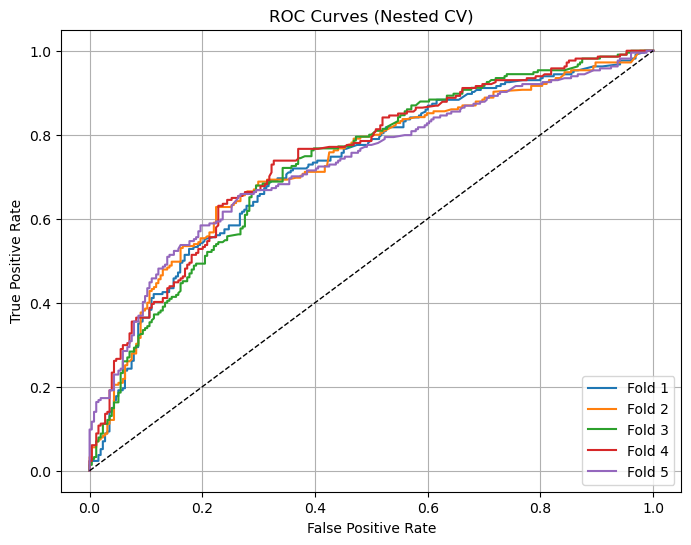

In [14]:
print("\nMean performance across outer folds:")
for metric_name, scores in outer_results.items():
    print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ROC curves for all folds
plt.figure(figsize=(8,6))
for i, (fpr, tpr) in enumerate(roc_curves, 1):
    plt.plot(fpr, tpr, label=f'Fold {i}')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Nested CV)')
plt.legend(loc='lower right')
plt.grid()
plt.show()